## Import

In [21]:
%load_ext autoreload
%autoreload 2
from src import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Dataset

Download the data from https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation

In [2]:
# Load the raw data from the CSV file
file_path = './data/Occupancy_Estimation.csv'
df_raw = pd.read_csv(file_path)

# Process the raw data using a custom function to prepare it for analysis
df = preprocessingdf(df_raw)  # df is the processed data ready for further analysis

# Extract specific columns needed for the final model evaluation
df_results = df[['Pirstatus','realoccupancy']]  # df_results is used for evaluating the model performance

# Display information about the dataframe 'df_results' to check its structure and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11322 entries, 2017-12-22 10:49:30 to 2017-12-26 09:10:00
Freq: 30s
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    11322 non-null  float64
 1   Co2            11322 non-null  float64
 2   Sound          11322 non-null  float64
 3   Light          11322 non-null  float64
 4   realoccupancy  11322 non-null  int32  
 5   Pirstatus      11322 non-null  int32  
dtypes: float64(4), int32(2)
memory usage: 530.7 KB


## Methods

### Sliding Window

In [3]:
# 'realoccupancy' is only for evaluation, it will not be included in traning in all methods
df_features = df.copy().drop('realoccupancy',axis=1)

df_features['pirstatus_smoothed'] = df_features['Pirstatus'].rolling(window=3, min_periods=1, center=True).max()
threshold = 0.5
df_results['Sliding Window'] = (df_features['pirstatus_smoothed'] > threshold).astype(int)

### Aggreated Data

In [31]:
df_features = df.copy()[['Pirstatus','realoccupancy']]
df_resampled = df_features.resample('10T').agg({
    'realoccupancy': 'max',  # Maximum value in each 10-minute interval
    'Pirstatus': 'sum'       # Sum of values in each 10-minute interval
})

df_resampled['Pirstatus_prob'] = df_resampled['Pirstatus'] / df_resampled['Pirstatus'].max()
df_resampled['Pirstatus_smooth'] = df_resampled['Pirstatus_prob'].rolling(window=5, min_periods=1,center=True).mean()
df_resampled['Aggreated Data'] = (df_resampled['Pirstatus_smooth']>0.2)
df_resampled = df_resampled[['Aggreated Data','realoccupancy']]

### Kmeans cluster

In [5]:
from sklearn.cluster import KMeans
df_features = df.copy().drop('realoccupancy',axis=1)
window_size = '0.2h' 
# Calculate rolling mean and standard deviation for feature scaling
df_mean = df_features.rolling(window_size).mean()
df_std = df_features.rolling(window_size).std()
# Combine mean and standard deviation into a single dataframe
df_stats = pd.concat([df_mean, df_std], axis=1, keys=['mean', 'std'])
df_stats = df_stats.dropna()
# Scale the features to a range of 0 to 1
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_stats)
df_scaled = np.concatenate((df_scaled, (np.array(df['Pirstatus'])[1:]/ 1.8).reshape(-1,1)), axis=1)
# Apply KMeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2)
df_stats['cluster'] = kmeans.fit_predict(df_scaled)
df_results['Kmeans cluster'] = df_stats['cluster']

### Random forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
# 'realoccupancy' is only for evaluation, it will not be included in traning in all methods
df_features = df.copy().drop('realoccupancy',axis=1)
# Select specific feature columns for the model input
X = df_features[['Temperature', 'Co2', 'Sound', 'Light']]
y = df_features['Pirstatus']
# Initialize and train a RandomForest classifier with class weight adjustments
model = RandomForestClassifier(n_estimators=50, class_weight={0: 1, 1: 3})
model.fit(X, y)
df_results['Random forest'] = model.predict(X)


### Transformer (Encoder only)

Prepare dataloader for transoformer training

In [7]:
df_features = df.copy().drop('realoccupancy',axis=1)
sequence_length = 18  
    

class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_col, seq_length):
        self.data = data
        self.target_col = target_col
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length + 1

    def __getitem__(self, idx):
        window = self.data.iloc[idx:idx+self.seq_length]
        if not self.is_time_continuous(window.index):
            return None  
        
        X = window.drop([self.target_col], axis=1).iloc[:self.seq_length].values
        y = window[self.target_col].iloc[:self.seq_length].values
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def is_time_continuous(self, times):
        expected_interval = pd.Timedelta(minutes=10)
        return all((times[i+1] - times[i]) <= expected_interval for i in range(len(times) - 1))
scaler = StandardScaler()

df_floats = df_features.select_dtypes(include=['float64'])
scaler = StandardScaler()
df_floats_standardized = pd.DataFrame(scaler.fit_transform(df_floats), columns=df_floats.columns, index=df_floats.index)
df_features = pd.concat([df_floats_standardized, df_features.select_dtypes(exclude=['float64'])], axis=1)

train_dataset = TimeSeriesDataset(df_features, 'Pirstatus', sequence_length)
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return torch.Tensor(), torch.Tensor() 
    Xs, ys = zip(*batch)
    return torch.stack(Xs), torch.stack(ys)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, collate_fn=collate_fn)


In [8]:
input_dim = 4
d_model = 64
nhead = 2
num_layers = 2
hidden_dim = 64


transformerencoder_model = TransformerModelEncoder(input_dim, d_model, nhead, num_layers, sequence_length)
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

num_epochs = 30
learning_rate = 0.001

transformerencoder_model.to(device)

weights = torch.tensor(5)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights.to(device))

transformer_optimizer = optim.Adam(transformerencoder_model.parameters(), lr=0.0001)
print("Training Transformer Model")
train_model(transformerencoder_model, train_loader, criterion, transformer_optimizer, num_epochs)

Training Transformer Model
Epoch [1/30], Loss: 0.2631
Epoch [2/30], Loss: 0.2085
Epoch [3/30], Loss: 0.2057
Epoch [4/30], Loss: 0.2022
Epoch [5/30], Loss: 0.1978
Epoch [6/30], Loss: 0.1946
Epoch [7/30], Loss: 0.1927
Epoch [8/30], Loss: 0.1913
Epoch [9/30], Loss: 0.1899
Epoch [10/30], Loss: 0.1887
Epoch [11/30], Loss: 0.1872
Epoch [12/30], Loss: 0.1864
Epoch [13/30], Loss: 0.1853
Epoch [14/30], Loss: 0.1838
Epoch [15/30], Loss: 0.1827
Epoch [16/30], Loss: 0.1822
Epoch [17/30], Loss: 0.1809
Epoch [18/30], Loss: 0.1803
Epoch [19/30], Loss: 0.1795
Epoch [20/30], Loss: 0.1794
Epoch [21/30], Loss: 0.1792
Epoch [22/30], Loss: 0.1780
Epoch [23/30], Loss: 0.1768
Epoch [24/30], Loss: 0.1765
Epoch [25/30], Loss: 0.1763
Epoch [26/30], Loss: 0.1758
Epoch [27/30], Loss: 0.1747
Epoch [28/30], Loss: 0.1744
Epoch [29/30], Loss: 0.1740
Epoch [30/30], Loss: 0.1736


In [9]:
features = df_features[['Temperature', 'Co2', 'Sound', 'Light']]
features = torch.tensor(features.values, dtype=torch.float32)

def create_batches(data, batch_size):
    return data.view(-1, batch_size, data.size(1))

max_divisible_size = (features.shape[0] // sequence_length) * sequence_length
features_batches = create_batches(features[:max_divisible_size], sequence_length).to(device)

transformerencoder_model.eval()
predictions = []

with torch.no_grad():
    for i in range(features_batches.size(0)):
        transformer_input_tensor = torch.tensor(features_batches[i], dtype=torch.float32).unsqueeze(0).to(device)
        transformer_output = torch.sigmoid(transformerencoder_model(transformer_input_tensor).cpu()).numpy().reshape(-1)
        transformer_output_binary = (transformer_output > 0.5).astype(int)
        predictions.extend(transformer_output_binary)
# 添加预测到DataFrame
df_results['transformerencoder'] = np.nan
df_results['transformerencoder'].iloc[:len(predictions)] = predictions

### Transformer (Encoder and Decoder)

In [ ]:
SRC_VOCAB_SIZE = 4
TGT_VOCAB_SIZE = 3
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)
weights = torch.tensor([1.0, 2, 0], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights,ignore_index=2)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
def train_epoch(model, optimizer):
    model.train()
    losses = 0   
    for src, tgt in train_loader:
        src = src.permute(1, 0, 2).to(device)
        tgt = tgt.permute(1, 0).to(device)
        padding_row = torch.full((1, src.size(1)), 2).to(device)
        tgt = torch.cat([tgt, padding_row], dim=0).to(device)
        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input,device)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        optimizer.zero_grad()
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1).long())
        loss.backward()
        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_loader))
from timeit import default_timer as timer
NUM_EPOCHS = 30

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


In [23]:
def translate(model, src, start_symbol=2):
    src = src.to(device)
    src_seq_len = src.shape[0]
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(sequence_length):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0),device)
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        # print(next_word)

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
   
    return ys.to('cpu')

features = df_features[['Temperature', 'Co2', 'Sound', 'Light']]
features = torch.tensor(features.values, dtype=torch.float32)
occupancy = df_features['Pirstatus'].values
tgt = torch.tensor(np.roll(occupancy, 1), dtype=torch.long)
tgt[0] = 2 

def create_batches(data, batch_size):
    return data.view(-1, batch_size, data.size(1))
max_divisible_size = (features.shape[0] // sequence_length) * sequence_length
features_batches = create_batches(features[:max_divisible_size], sequence_length).to(device)
tgt_batches = create_batches(tgt[:max_divisible_size].unsqueeze(-1), sequence_length).to(device)

transformer.eval()
predictions = []

with torch.no_grad():
    for i in range(features_batches.size(0)):
    
        src = features_batches[i].unsqueeze(0).permute(1, 0, 2) 
        
        output = translate(transformer, src)[1:]
        pred = output.reshape(-1)  
        predictions.extend(pred.squeeze().tolist())
df_results['Transformer_Prediction'] = np.nan
df_results['Transformer_Prediction'].iloc[:len(predictions)] = predictions

## Evaluation

Since there is some randomness in the model training, the evaluation results are slightly different from those shown in the paper.

In [34]:
df_results = df_results.dropna()
df_results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11321 entries, 2017-12-22 10:50:00 to 2017-12-26 09:10:00
Freq: 30s
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pirstatus               11321 non-null  int32  
 1   realoccupancy           11321 non-null  int32  
 2   Sliding Window          11321 non-null  int32  
 3   Kmeans cluster          11321 non-null  float64
 4   Random forest           11321 non-null  int32  
 5   transformerencoder      11321 non-null  float64
 6   Transformer_Prediction  11321 non-null  float64
dtypes: float64(3), int32(4)
memory usage: 530.7 KB


### Direct mapping (baseline)

Confusion Matrix:
 [[9571   22]
 [ 698 1030]]
Accuracy: 0.936401377970144
Precision: 0.9790874524714829
Recall: 0.5960648148148148
F1 Score: 0.7410071942446043
AUC: 0.796885737960936


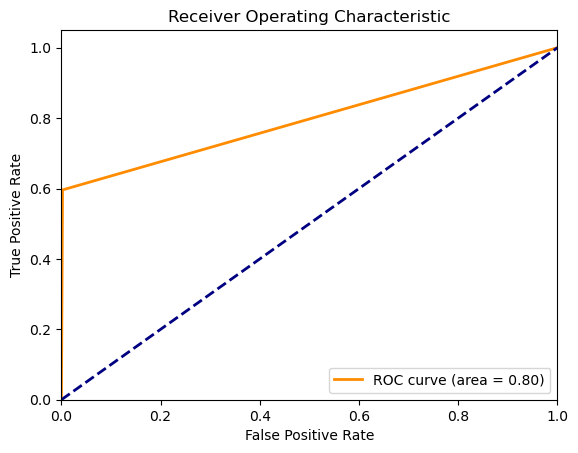

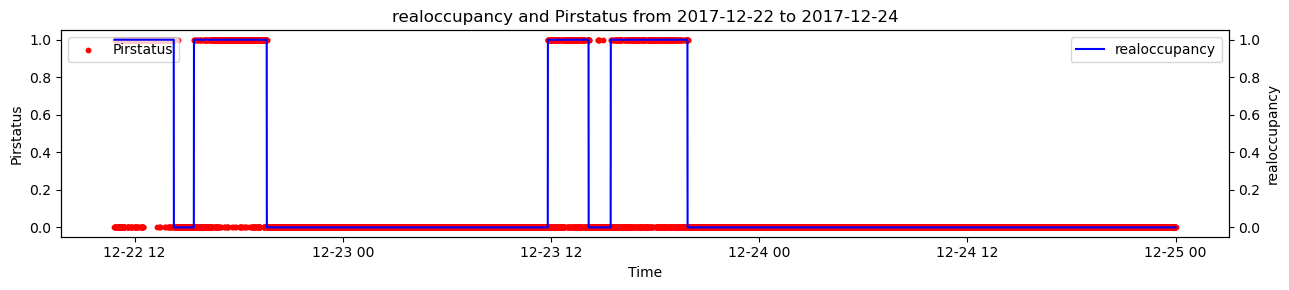

In [35]:
evaluation(df_results,'realoccupancy','Pirstatus')

### Sliding Window

Confusion Matrix:
 [[9548   45]
 [ 325 1403]]
Accuracy: 0.9673173747902128
Precision: 0.9689226519337016
Recall: 0.8119212962962963
F1 Score: 0.8835012594458438
AUC: 0.9036151879167295


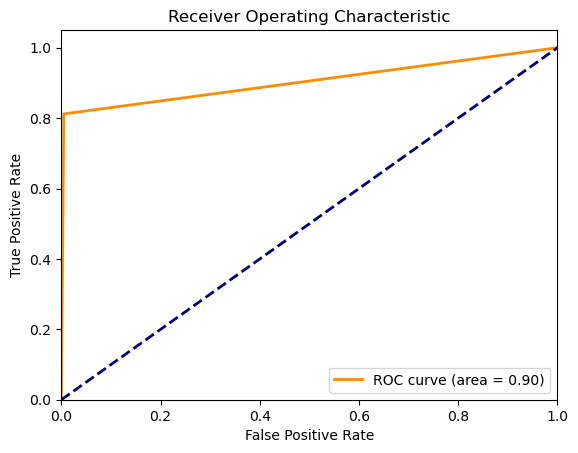

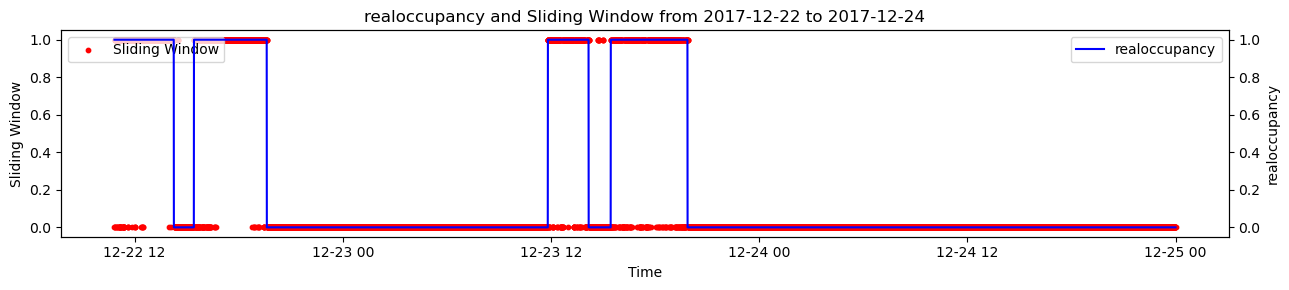

In [36]:
evaluation(df_results,'realoccupancy','Sliding Window')

### Aggreated Data

Confusion Matrix:
 [[474   3]
 [  5  86]]
Accuracy: 0.9859154929577465
Precision: 0.9662921348314607
Recall: 0.945054945054945
F1 Score: 0.9555555555555557
AUC: 0.9693828184394222


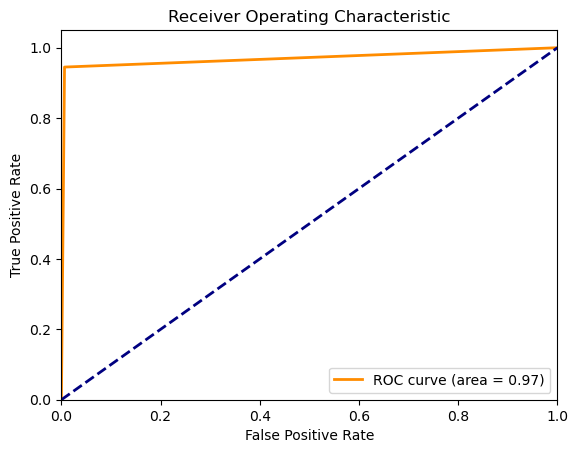

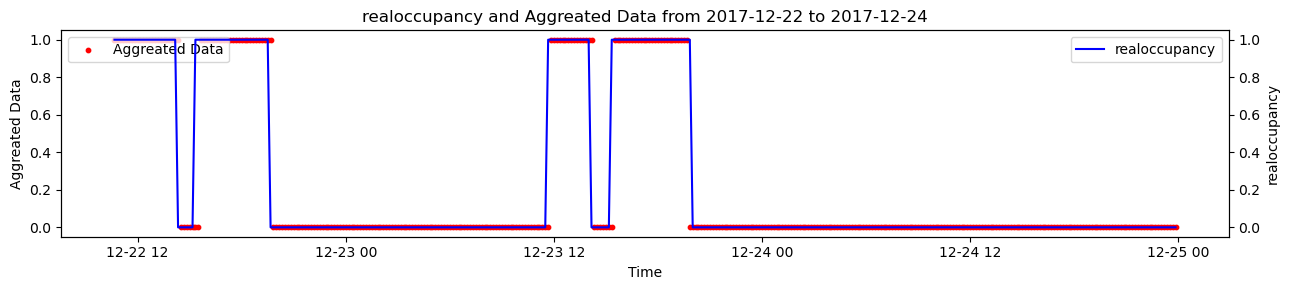

In [37]:
evaluation(df_resampled,'realoccupancy','Aggreated Data')

### Kmeans cluster

Confusion Matrix:
 [[9447  146]
 [  27 1701]]
Accuracy: 0.9847186644289374
Precision: 0.9209528965890633
Recall: 0.984375
F1 Score: 0.9516083916083916
AUC: 0.9845777845825081


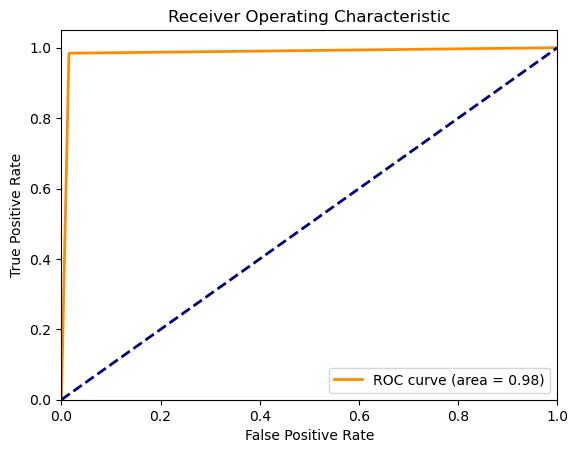

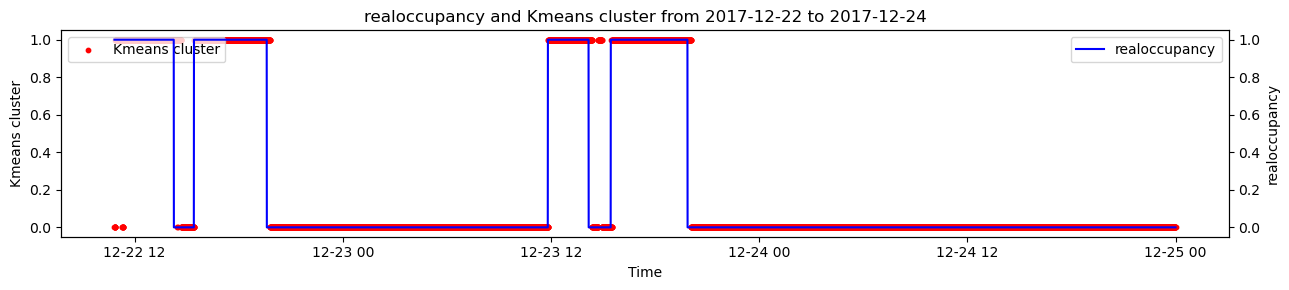

In [38]:
evaluation(df_results,'realoccupancy','Kmeans cluster')

### Random forest

Confusion Matrix:
 [[9572   21]
 [ 698 1030]]
Accuracy: 0.9364897093896299
Precision: 0.9800190294957184
Recall: 0.5960648148148148
F1 Score: 0.7412738395106153
AUC: 0.7969378592994121


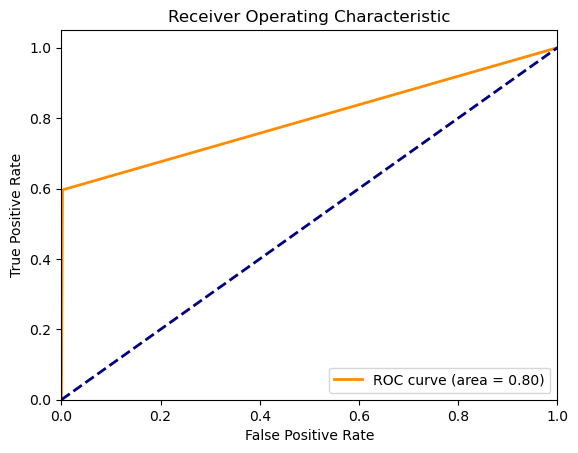

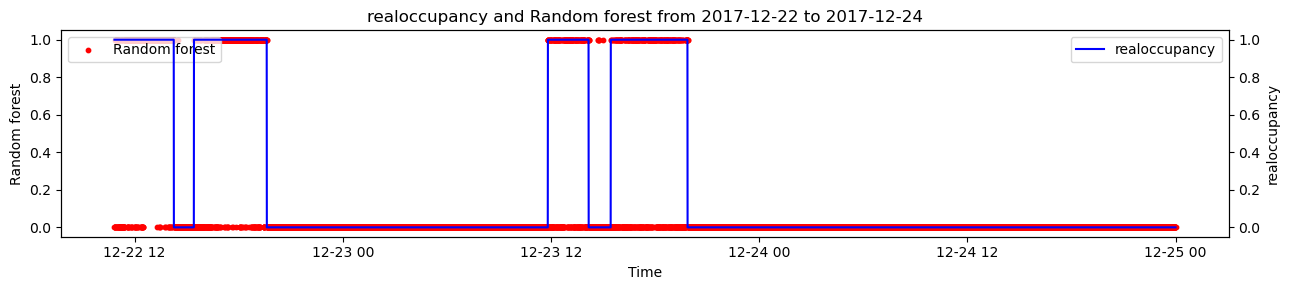

In [39]:
evaluation(df_results,'realoccupancy','Random forest')

### Transformer (Encoder only)

Confusion Matrix:
 [[9573   20]
 [ 111 1617]]
Accuracy: 0.9884285840473457
Precision: 0.9877825290164935
Recall: 0.9357638888888888
F1 Score: 0.9610698365527489
AUC: 0.966839517674925


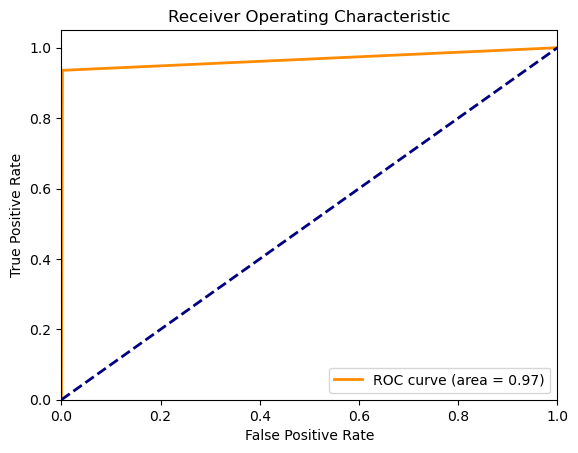

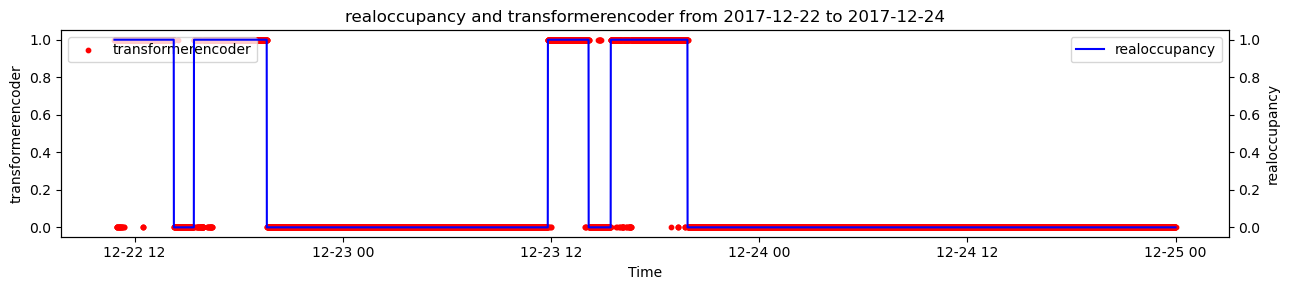

In [40]:
evaluation(df_results,'realoccupancy','transformerencoder')

### Transformer (Encoder and Decoder)

Confusion Matrix:
 [[9591    2]
 [ 597 1131]]
Accuracy: 0.9470894797279392
Precision: 0.9982347749338041
Recall: 0.6545138888888888
F1 Score: 0.7906326459279972
AUC: 0.8271527017674923


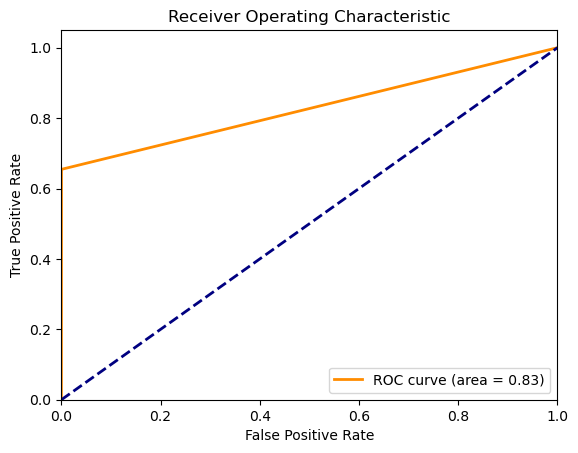

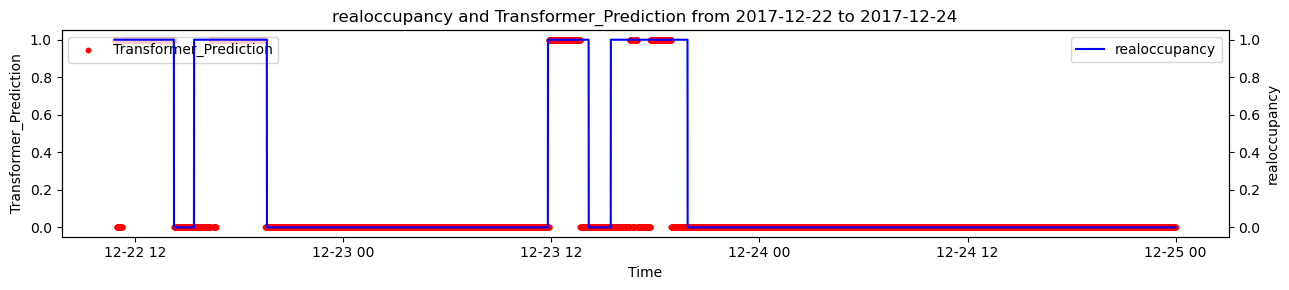

In [41]:
evaluation(df_results,'realoccupancy','Transformer_Prediction')